In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split


from scipy.fft import fft, fftfreq


warnings.filterwarnings(action='ignore')
torch.set_float32_matmul_precision('high')

In [2]:
data_folder = Path("D:\\F. Export data\\부족윤활")
lack231222 = data_folder/ 'RMS_231222_lacklub_1s.csv'
lack231222 = pd.read_csv(lack231222)
lack231222.head()

,Time,RMS
0,0.000000,0.260380
1,0.016672,0.256666
2,0.033343,0.245744
3,0.050015,0.243500
4,0.066687,0.232709


In [3]:
time = lack231222.Time.to_list()
signal = lack231222.RMS.to_list()

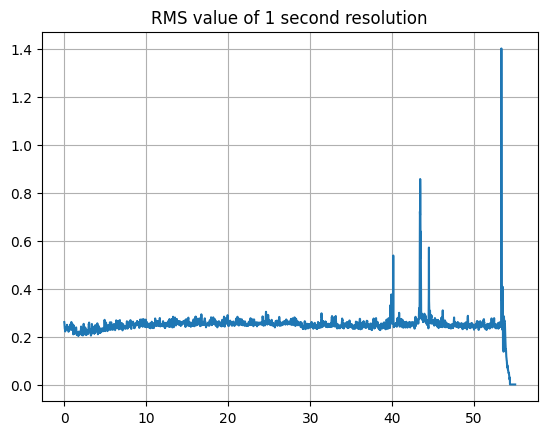

In [4]:
plt.Figure(figsize=(10,4))
plt.plot(time,signal)
plt.title("RMS value of 1 second resolution")
plt.grid(True)
plt.show()

In [5]:
# Normalize data
def normalize(input):
    mean = np.mean(input)
    input = input - mean
    std = np.std(input)
    input /= std
    return input,mean,std

signal_norm, signal_mean, signal_std = normalize(signal)
len(signal_norm)

3300

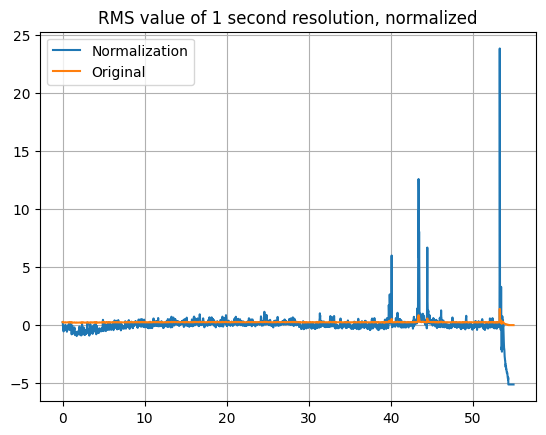

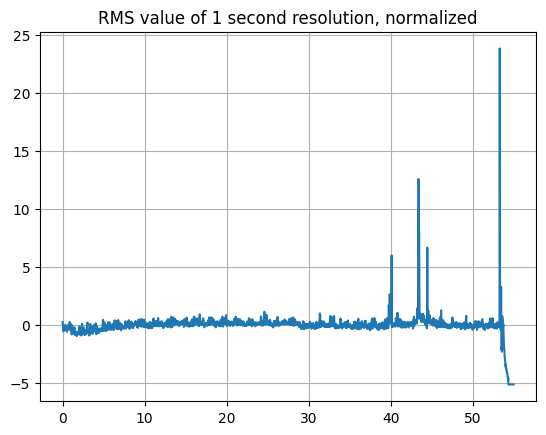

In [6]:
plt.Figure(figsize=(10,4))
plt.plot(time,signal_norm, label = "Normalization")
plt.plot(time, signal,label = "Original")
plt.title("RMS value of 1 second resolution, normalized")
plt.legend()
#plt.ylim([0,1.5])
plt.grid(True)
plt.show()

plt.Figure(figsize=(10,4))
plt.plot(time,signal_norm, label = "Normalization")
plt.title("RMS value of 1 second resolution, normalized")
#plt.ylim([0,1.5])
plt.grid(True)
plt.show()

In [7]:
print(f"Mean of signal {signal_mean}")
print(f"Standard deviation of signal {signal_std}")

Mean of signal 0.24788451956545451
Standard deviation of signal 0.04835297159825277


In [8]:
# Split data
training_norm = signal_norm[0:2100] # Training data is the first 30 minutes
test_norm = signal_norm[2100:] # Test data is the remain

In [ ]:
# Convert 2D data to 3D data
time_step = 60

def converter(input, step = time_step):
    out = []
    for i in range (len(input)-step):
        out.append(input[i:(i+step)])
    return np.expand_dims(out,axis=2) # Add axis2 into the data

In [10]:
x_train = converter(training_norm)
x_test = converter(test_norm) 

In [11]:
print(x_train.shape)
print(x_test.shape)

(2070, 30, 1)
(1170, 30, 1)


In [12]:
# Split training - validation data set
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
dataset = TensorDataset(x_train_tensor,x_train_tensor) # Features are also label
val_size = int(0.2*len(dataset))
train_size = len(dataset)- val_size
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

batchsize = 15
train_loader = DataLoader(train_dataset, batch_size=batchsize,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize,shuffle=True)

In [13]:
print(f'Size of train data tensor: {x_train_tensor.shape}')
print(type(train_loader))
data_iter = iter(train_loader)
firstbatchdata, firstbatchlabel = next(data_iter)
print(f"data batch shape {firstbatchdata.shape}")
print(f"Label batch shape: {firstbatchlabel.shape}")

Size of train data tensor: torch.Size([2070, 30, 1])
<class 'torch.utils.data.dataloader.DataLoader'>
data batch shape torch.Size([15, 30, 1])
Label batch shape: torch.Size([15, 30, 1])


In [ ]:
n_steps = x_train.shape[1] #60 data points
n_features = x_train.shape[2] # = 1 channel
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
class ConvLSTMAutoencoder(nn.Module):
    def __init__(self, n_steps, n_features):
        super(ConvLSTMAutoencoder, self).__init__() # Inheriting from base class nn.Module, lấy những methods cần thiết chứ không bê tất
        self.n_steps = n_steps
        self.n_features = n_features

        # Conv1D encoder layer
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=128, # 32 kernels
            kernel_size=7, #kernel size (7,1)
            padding='same',  # Use manual padding below
            dilation=1
        )

        # LSTM encoder
        self.lstm1 = nn.LSTM(
            input_size=128,
            hidden_size=64,
            dropout= 0.1,
            batch_first=True # input, output tensors are provided as (batch,seq_len, features)
        )
        #self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=True, dropout=0.1)
        self.lstm1_1 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True,dropout= 0.1)
        self.lstm1_2 = nn.LSTM(input_size=32, hidden_size=16, batch_first=True,dropout= 0.1)
        # LSTM decoder
        self.lstm2_1 = nn.LSTM(input_size=16, hidden_size=32,dropout= 0.1, batch_first=True)
        self.lstm2_2 = nn.LSTM(input_size=32, hidden_size=64,dropout= 0.1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64,hidden_size=128,dropout= 0.1,batch_first=True)

        # Conv1D decoder layer
        self.conv2 = nn.Conv1d(
            in_channels=128,
            out_channels=n_steps,
            kernel_size=7,
            padding='same',
            dilation=1
        )

        # TimeDistributed Dense(1)
        self.fc = nn.Linear(n_steps, 1)
        self.activation = nn.ReLU()

    def forward(self, x): #the process of passing input data through the layers of a neural network to obtain an output
        # Input shape: (batch_size, n_steps = 30, n_features = 1)
        # Conv1D in PyTorch expects: (batch_size, channels=n_features, seq_len=n_steps)
        x = x.permute(0, 2, 1)  # (B = 15, C = 1, T = 30), batch size would be set up later, rearrange the input size
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # rearrange back to (Batch, T:n_steps = 30, C: 32) for LSTM

        # LSTM encoder
        x, (_, _) = self.lstm1(x)
        x = self.activation(x)
        x, (_,_) = self.lstm1_1(x)
        x = self.activation(x)
        _, (h_n, _) = self.lstm1(x) # h_n is the compressed version of the whole input (hidden state of the last batch of the input (last row))
        h = h_n[0]  # (B, hidden) # Taking out only the batch size and number of features

        # RepeatVector
        h_repeated = h.unsqueeze(1).repeat(1, self.n_steps, 1)  # (B, T, hidden)

        # LSTM decoder
        h_1,(_,_) = self.lstm2_1(h_repeated)
        h_1 = self.activation(h_1)
        h_1,(_,_) = self.lstm2_2(h_1)
        h_1 = self.activation(h_1)
        x_decoded, _ = self.lstm2(h_1)

        # Conv1D decoder
        x_decoded = x_decoded.permute(0, 2, 1)  # (B =128, C=25, T)
        x_decoded = self.conv2(x_decoded)

        # Final TimeDistributed Dense layer
        x_decoded = x_decoded.permute(0, 2, 1)  # (B, T, C=32)
        output = self.fc(x_decoded)  # (B, T, 1)

        return output
model = ConvLSTMAutoencoder(n_steps=x_train.shape[1], n_features=n_features)
model.to(device)  # Move model to GPU or CPU

# Optimizer and Loss
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001,weight_decay=1e-5)
criterion = nn.HuberLoss()

# Print summary-like info
print(model)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")


ConvLSTMAutoencoder(
  (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=same)
  (lstm1): LSTM(128, 64, batch_first=True, dropout=0.1)
  (lstm1_1): LSTM(64, 32, batch_first=True, dropout=0.1)
  (lstm1_2): LSTM(32, 16, batch_first=True, dropout=0.1)
  (lstm2_1): LSTM(16, 32, batch_first=True, dropout=0.1)
  (lstm2_2): LSTM(32, 64, batch_first=True, dropout=0.1)
  (lstm2): LSTM(64, 128, batch_first=True, dropout=0.1)
  (conv2): Conv1d(128, 30, kernel_size=(7,), stride=(1,), padding=same)
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (activation): ReLU()
)
Current Device: 0


In [56]:
# Initialize training setup
epochs = 100
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    


    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")
    print(batch_x.device)

Epoch 1/100 - Train Loss: 0.0413 - Val Loss: 0.0248
Epoch 2/100 - Train Loss: 0.0233 - Val Loss: 0.0208
Epoch 3/100 - Train Loss: 0.0214 - Val Loss: 0.0201
Epoch 4/100 - Train Loss: 0.0208 - Val Loss: 0.0199
Epoch 5/100 - Train Loss: 0.0205 - Val Loss: 0.0195
Epoch 6/100 - Train Loss: 0.0202 - Val Loss: 0.0193
Epoch 7/100 - Train Loss: 0.0200 - Val Loss: 0.0191
Epoch 8/100 - Train Loss: 0.0198 - Val Loss: 0.0191
Epoch 9/100 - Train Loss: 0.0196 - Val Loss: 0.0188
Epoch 10/100 - Train Loss: 0.0195 - Val Loss: 0.0187
Epoch 11/100 - Train Loss: 0.0193 - Val Loss: 0.0186
Epoch 12/100 - Train Loss: 0.0192 - Val Loss: 0.0185
Epoch 13/100 - Train Loss: 0.0191 - Val Loss: 0.0185
Epoch 14/100 - Train Loss: 0.0190 - Val Loss: 0.0184
Epoch 15/100 - Train Loss: 0.0189 - Val Loss: 0.0183
Epoch 16/100 - Train Loss: 0.0189 - Val Loss: 0.0183
Epoch 17/100 - Train Loss: 0.0188 - Val Loss: 0.0182
Epoch 18/100 - Train Loss: 0.0187 - Val Loss: 0.0181
Epoch 19/100 - Train Loss: 0.0186 - Val Loss: 0.0181
Ep

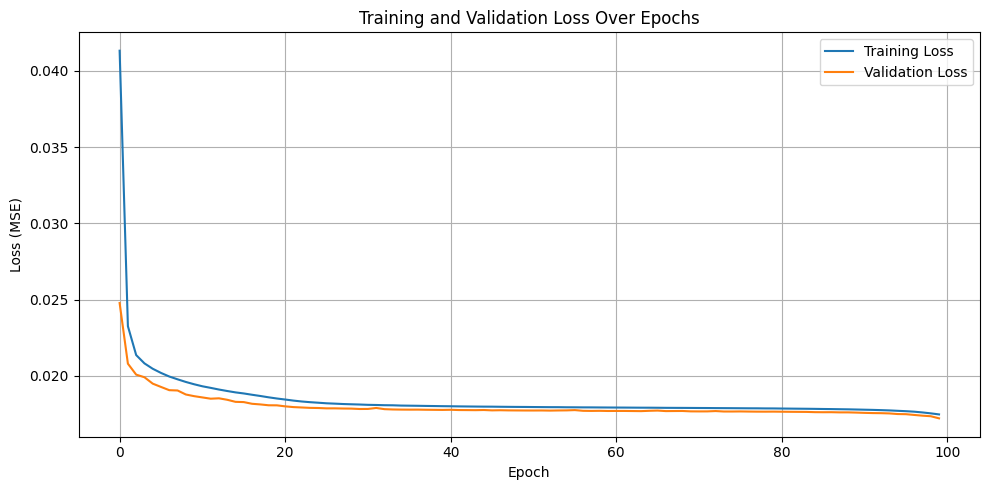

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

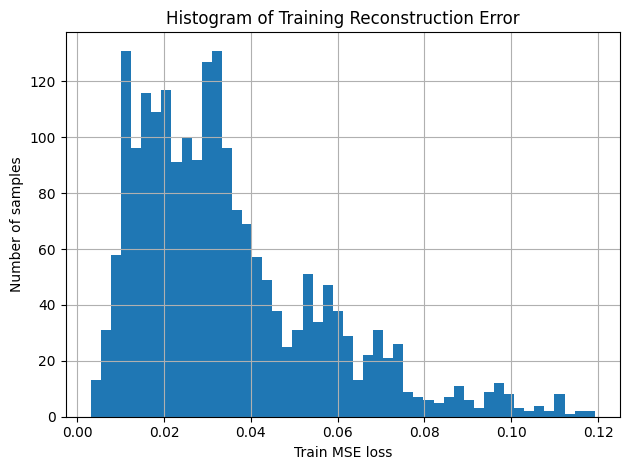

Reconstruction error threshold: 0.11924936


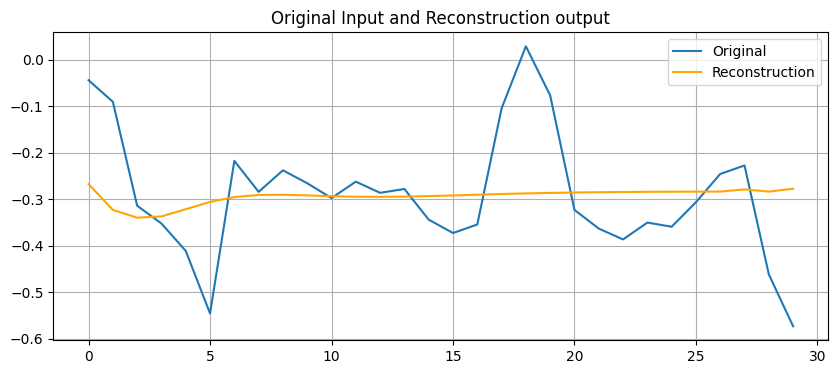

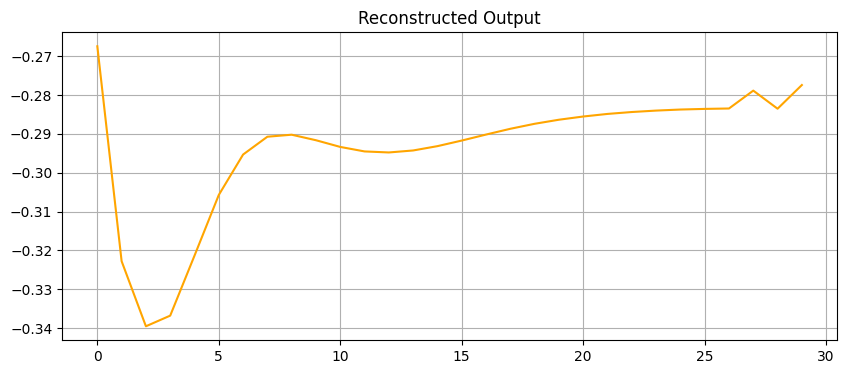

[-0.41089344]
[-0.3213633]
[[4.9809139e-02]
 [5.3879436e-02]
 [6.6134369e-04]
 [2.3428355e-04]
 [8.0156457e-03]
 [5.7382472e-02]
 [6.0471245e-03]
 [4.4431647e-05]
 [2.7456938e-03]
 [6.7964173e-04]
 [1.6427024e-05]
 [1.0479405e-03]
 [7.4075324e-05]
 [2.6932309e-04]
 [2.5615115e-03]
 [6.5209409e-03]
 [4.0959059e-03]
 [3.3770241e-02]
 [9.9868007e-02]
 [4.3850712e-02]
 [1.3932731e-03]
 [6.0996418e-03]
 [1.0377636e-02]
 [4.3670358e-03]
 [5.6636301e-03]
 [5.1542989e-04]
 [1.4304614e-03]
 [2.6484320e-03]
 [3.1600475e-02]
 [8.7249398e-02]]


In [58]:
# Make sure model is in eval mode and data is on correct device
model.eval()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

# 1. Predict training data
with torch.no_grad():
    x_train_pred = model(x_train_tensor)

# 2. Move tensors to CPU and convert to NumPy
x_train_pred_np = x_train_pred.cpu().numpy()
x_train_np = x_train_tensor.cpu().numpy()

# 3. Compute MSE per sample (mean over all time steps and features)
# Assume shape is (batch_size, time_steps, features)
train_mse_loss = np.mean(np.square(x_train_pred_np - x_train_np), axis=(1, 2))  # axis=1 for time only, or (1,2) for full sequence

# 4. Plot histogram of reconstruction loss
plt.hist(train_mse_loss, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Training Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Set anomaly threshold
threshold = np.max(train_mse_loss)
print("Reconstruction error threshold:", threshold)

# 6. Plot first input vs reconstruction
plt.figure(figsize=(10, 4))
plt.plot(x_train_np[2], label="Original")
plt.plot(x_train_pred_np[2], label="Reconstruction", color='orange')
plt.title("Original Input and Reconstruction output")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_train_pred_np[2], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
plt.show()

#7
x_train_1 = x_train_np[2]
x_train_pred_1 = x_train_pred_np[2]
print(x_train_1[4])
print(x_train_pred_1[4])
print((x_train_1-x_train_pred_1)**2)

In [59]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    x_test_pred_tensor = model(x_test_tensor)

x_test_pred = x_test_pred_tensor.cpu().numpy()
x_test_np = x_test_tensor.cpu().numpy()

Reconstruction error threshold: 23.53907


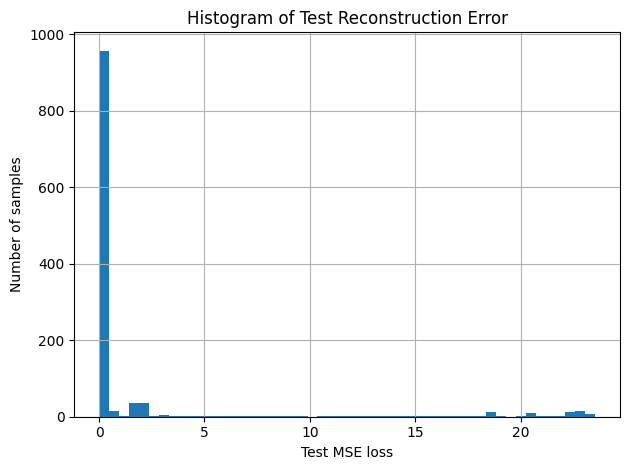

Number of anomaly samples: 228
Indices of anomaly samples: [ 257  258  259  260  261  262  263  264  265  266  267  268  269  270
  271  272  273  274  275  276  277  278  279  280  281  282  283  284
  285  286  287  288  289  290  291  292  293  294  295  296  297  298
  299  300  301  302  303  304  305  306  307  308  471  472  473  474
  475  476  477  478  479  480  481  482  483  484  485  486  487  488
  489  490  491  492  493  494  495  496  497  498  499  500  501  502
  503  504  505  506  507  508  509  510  538  539  540  541  542  543
  544  545  546  547  548  549  550  551  552  553  554  555  556  557
  558  559  560  561  562  563  564  565  566  567  568  569  570  571
 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081
 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123
 1124 1125 1126 11

In [60]:
test_mse_loss = np.mean(np.square(x_test_pred - x_test_np), axis=(1, 2))  # Shape: (num_samples,)
threshold_test = np.max(test_mse_loss)
print("Reconstruction error threshold:", threshold_test)
plt.hist(test_mse_loss, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Test Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# threshold must be defined earlier (e.g., from training data)
anomalies = test_mse_loss > threshold

print("Number of anomaly samples:", np.sum(anomalies))
print("Indices of anomaly samples:", np.where(anomalies)[0])

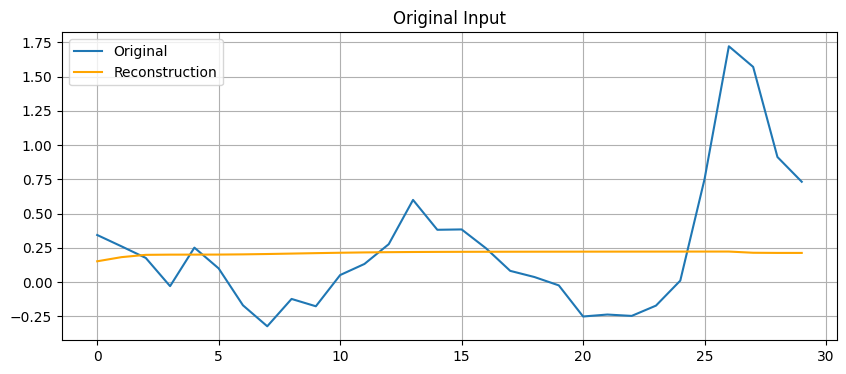

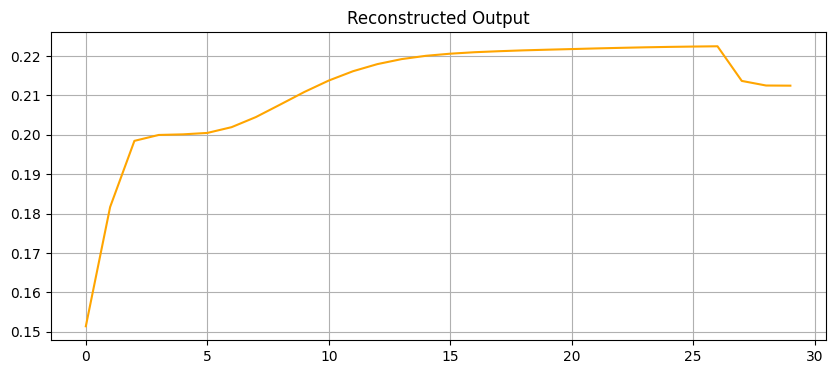

In [61]:
# Plot first input vs reconstruction of test data
plt.figure(figsize=(10, 4))
plt.plot(x_test_np[260], label="Original")
plt.plot(x_test_pred[260], label="Reconstruction", color='orange')
plt.title("Original Input")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_test_pred[260], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
plt.show()

In [62]:
# Extracting the indices of anomalous
anomalous_data_indices = []

for data_idx in range(time_step - 1, len(test_norm) - time_step + 1):
    time_series = range(data_idx - time_step + 1, data_idx)
    if all(anomalies[j] for j in time_series):
        anomalous_data_indices.append(data_idx)

In [63]:
anomalous_data = test_norm[anomalous_data_indices]
time_test = time[2100:]
anomalies_time = []
for i in anomalous_data_indices:
    anomalies_time.append(time_test[i])

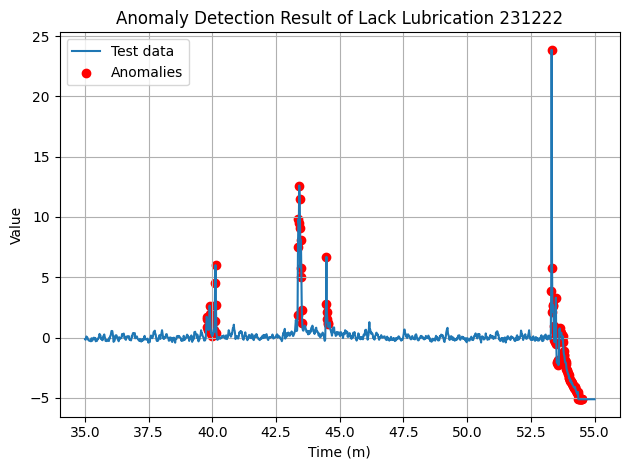

In [64]:
plt.Figure(figsize=(10,4))
plt.plot(time_test,test_norm,label= "Test data")
plt.scatter(anomalies_time,anomalous_data,color = 'red',label="Anomalies" )
plt.legend()
plt.title("Anomaly Detection Result of Lack Lubrication 231222")
plt.xlabel("Time (m)")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
convo1 = nn.Conv1d(in_channels=3,out_channels=4,kernel_size=2,padding='same',dilation=1)
x = torch.tensor(np.array([[[0,1,2],[1,5,1],[3,3,0],[2,0,0],[0,1,0]],[[0,1,2],[1,5,1],[3,3,0],[2,0,0],[0,1,0]]])).type(torch.float)
x_permuted = x.permute(0,2,1)
print(f"Shape of permuted x: {x_permuted.shape}")
y = convo1(x_permuted)
print(f"Weight of the kernel: {convo1.weight}")
print(f"Bias of the kernel: {convo1.bias}")
print(x_permuted)
print(f"Outcome of the convo:{y.shape}")
print(y)
y= y.permute(0,2,1)
print(y.shape)
print(f"Final output: {y}")

Shape of permuted x: torch.Size([2, 3, 5])
Weight of the kernel: Parameter containing:
tensor([[[-0.3338, -0.0860],
         [ 0.2622, -0.2892],
         [ 0.1942,  0.1739]],

        [[ 0.1063,  0.2656],
         [-0.2415, -0.1855],
         [-0.0765,  0.3190]],

        [[-0.1938, -0.1198],
         [-0.2801, -0.0259],
         [ 0.1399,  0.0563]],

        [[ 0.2792, -0.1029],
         [ 0.0083, -0.3149],
         [-0.2646,  0.2839]]], requires_grad=True)
Bias of the kernel: Parameter containing:
tensor([-0.0531, -0.0490,  0.1708, -0.1611], requires_grad=True)
tensor([[[0., 1., 3., 2., 0.],
         [1., 5., 3., 0., 1.],
         [2., 1., 0., 0., 0.]],

        [[0., 1., 3., 2., 0.],
         [1., 5., 3., 0., 1.],
         [2., 1., 0., 0., 0.]]])
Outcome of the convo:torch.Size([2, 4, 5])
tensor([[[-0.7602, -0.0069, -0.4398, -1.0098,  0.2092],
         [-0.7865, -0.9864,  0.0766, -0.0219, -0.2905],
         [-0.0226, -1.7209, -1.4906, -0.2427, -0.1094],
         [-2.0751, -1.3582,  

In [66]:
lstm1 = nn.LSTM(input_size=4,hidden_size=3,batch_first=True)
h_t, (final_hidden_state, final_cell_state) = lstm1(y)
print(f"a value: {h_t}")
print(f"z value: {final_hidden_state}")
print(f"b value: {final_cell_state}")

print("=== LSTM Parameters ===")
print("Input-Hidden Weights (W_ih):")
print(lstm1.weight_ih_l0)

print("\nHidden-Hidden Weights (W_hh):")
print(lstm1.weight_hh_l0)

print("\nInput-Hidden Bias (b_ih):")
print(lstm1.bias_ih_l0)

print("\nHidden-Hidden Bias (b_hh):")
print(lstm1.bias_hh_l0)

a value: tensor([[[-0.3040, -0.2051, -0.1012],
         [-0.3484, -0.2098, -0.3195],
         [-0.1297, -0.1553, -0.0309],
         [-0.1936, -0.0639,  0.0569],
         [-0.3125, -0.0408, -0.0768]],

        [[-0.3040, -0.2051, -0.1012],
         [-0.3484, -0.2098, -0.3195],
         [-0.1297, -0.1553, -0.0309],
         [-0.1936, -0.0639,  0.0569],
         [-0.3125, -0.0408, -0.0768]]], grad_fn=<TransposeBackward0>)
z value: tensor([[[-0.3125, -0.0408, -0.0768],
         [-0.3125, -0.0408, -0.0768]]], grad_fn=<StackBackward0>)
b value: tensor([[[-0.5670, -0.0885, -0.1222],
         [-0.5670, -0.0885, -0.1222]]], grad_fn=<StackBackward0>)
=== LSTM Parameters ===
Input-Hidden Weights (W_ih):
Parameter containing:
tensor([[ 2.3566e-01, -1.6363e-01,  5.5594e-02, -7.2116e-03],
        [-5.4285e-01,  4.6817e-01,  2.5766e-01,  2.4802e-01],
        [ 6.0051e-02,  4.1082e-01, -5.5312e-01, -1.8041e-01],
        [-2.0879e-01, -3.2167e-01, -7.1999e-02, -1.8368e-01],
        [ 3.3634e-01, -1.729

In [67]:
a = final_hidden_state[0]
a_1 = a.unsqueeze(1)
a_repeated = a.unsqueeze(1).repeat(1, n_steps, 1)
print(f"a value is {a} and the shape is {a.shape}")
print(f"unsqueeze value of a is {a_1} and the shape is {a_1.shape}")
print(a_repeated.shape)
print(f"Comparing tensors between unsqueeze {a_1} & latent representation {final_hidden_state} {torch.equal(a_1, final_hidden_state)}")
a_2 = final_hidden_state.repeat(1,60,1)
print(a_2.shape)

a value is tensor([[-0.3125, -0.0408, -0.0768],
        [-0.3125, -0.0408, -0.0768]], grad_fn=<SelectBackward0>) and the shape is torch.Size([2, 3])
unsqueeze value of a is tensor([[[-0.3125, -0.0408, -0.0768]],

        [[-0.3125, -0.0408, -0.0768]]], grad_fn=<UnsqueezeBackward0>) and the shape is torch.Size([2, 1, 3])
torch.Size([2, 30, 3])
Comparing tensors between unsqueeze tensor([[[-0.3125, -0.0408, -0.0768]],

        [[-0.3125, -0.0408, -0.0768]]], grad_fn=<UnsqueezeBackward0>) & latent representation tensor([[[-0.3125, -0.0408, -0.0768],
         [-0.3125, -0.0408, -0.0768]]], grad_fn=<StackBackward0>) False
torch.Size([1, 120, 3])
